In [ ]:
import warnings
from pprint import pprint
warnings.filterwarnings('ignore')

In [ ]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv('./credential/cred.env')

# Get the API key from the environment variables
api_key = os.environ.get("API_KEY")

# Check if the API key was found
if api_key:
  print("API Key loaded successfully.")
else:
  print("API Key not found in the environment variables.")
os.environ["OPENAI_API_KEY"] = api_key

API Key loaded successfully.



# Chapter 6. Agent Architecture

โดยอาศัยสถาปัตยกรรมที่อธิบายไว้ในบทที่ 5 บทนี้จะกล่าวถึงสิ่งที่อาจเป็นสถาปัตยกรรม LLM ที่สำคัญที่สุดในปัจจุบัน นั่นคือ สถาปัตยกรรมตัวแทน ก่อนอื่น เราจะแนะนำสิ่งที่ทำให้ตัวแทน LLM มีความโดดเด่น จากนั้นเราจะแสดงวิธีการสร้างและขยายสำหรับกรณีการใช้งานทั่วไป

ในสาขาปัญญาประดิษฐ์ มีประวัติศาสตร์อันยาวนานในการสร้างตัวแทน (อัจฉริยะ) ซึ่งสามารถกำหนดได้ง่ายที่สุดว่า "สิ่งที่กระทำ" ตามคำกล่าวของ Stuart Russell และ Peter Norvig ในตำรา Artificial Intelligence (Pearson, 2020) ของพวกเขา คำว่ากระทำนั้นจริง ๆ แล้วมีความหมายมากกว่าที่เห็น:

- การกระทำต้องมีความสามารถในการตัดสินใจว่าจะทำอะไร

- การตัดสินใจว่าจะทำอะไร หมายถึงการเข้าถึงแนวทางปฏิบัติที่เป็นไปได้มากกว่าหนึ่งวิธี หลังจากทั้งหมด การตัดสินใจโดยไม่มีทางเลือกก็ไม่ใช่การตัดสินใจเลย

- เพื่อที่จะตัดสินใจ ตัวแทนยังต้องเข้าถึงข้อมูลเกี่ยวกับสภาพแวดล้อมภายนอก (ทุกสิ่งที่อยู่นอกตัวแทนเอง)



ดังนั้น แอปพลิเคชัน LLM ตัวแทนต้องเป็นแอปพลิเคชันที่ใช้ LLM เพื่อเลือกจากหนึ่งในหลาย ๆ แนวทางปฏิบัติที่เป็นไปได้ โดยพิจารณาจากบริบทบางอย่างเกี่ยวกับสถานะปัจจุบันของโลกหรือสถานะถัดไปที่ต้องการ แอตทริบิวต์เหล่านี้มักจะถูกนำไปใช้โดยการผสมผสานเทคนิคการเขียนพรอมต์สองอย่างที่เราพบครั้งแรกในคำนำ:

- **Tool calling**
รวมฟังก์ชันภายนอกในพรอมต์ที่ LLM สามารถใช้ประโยชน์ได้ (นั่นคือ การกระทำที่สามารถตัดสินใจดำเนินการได้) และคำแนะนำเกี่ยวกับวิธีการจัดรูปแบบตัวเลือกในเอาต์พุตที่สร้างขึ้น คุณจะได้เห็นในไม่ช้าว่าสิ่งนี้มีลักษณะอย่างไรในพรอมต์

- **Chain-of-thought**
นักวิจัยพบว่า LLM “ตัดสินใจได้ดีขึ้น” เมื่อได้รับคำแนะนำให้ใช้เหตุผลเกี่ยวกับปัญหาที่ซับซ้อนโดยการแบ่งย่อยเป็นขั้นตอนย่อยที่ต้องดำเนินการตามลำดับ ซึ่งโดยปกติจะทำได้โดยการเพิ่มคำแนะนำในลักษณะของ “คิดทีละขั้นตอน” หรือรวมตัวอย่างของคำถามและการแยกย่อยเป็นหลายขั้นตอน/การกระทำ

นี่คือตัวอย่างพรอมต์ที่ใช้ทั้งการเรียกใช้งานเครื่องมือและ chain-of-thought:

```
Tools:
search: this tool accepts a web search query and returns the top results.
calculator: this tool accepts math expressions and returns their result.

If you want to use tools to arrive at the answer, output the list of tools and
inputs in CSV format, with the header row: tool,input.

Think step by step; if you need to make multiple tool calls to arrive at the
answer, return only the first one.

How old was the 30th president of the United States when he died?

tool,input
```

และเอาต์พุต เมื่อเรียกใช้กับ gpt-35-turbo-instruct ที่อุณหภูมิ 0 (เพื่อให้แน่ใจว่า LLM ทำตามรูปแบบเอาต์พุตที่ต้องการ CSV) และบรรทัดใหม่เป็นลำดับหยุด (ซึ่งสั่งให้ LLM หยุดการสร้างเอาต์พุตเมื่อถึงอักขระนี้) สิ่งนี้ทำให้ LLM สร้างการกระทำเดียว (ตามที่คาดไว้ ตามที่พรอมต์ขอ):
```
search,30th president of the United States
```

LLM และโมเดลแชทล่าสุดได้รับการปรับแต่งอย่างละเอียดเพื่อปรับปรุงประสิทธิภาพสำหรับการเรียกใช้งานเครื่องมือและแอปพลิเคชัน chain-of-thought ทำให้ไม่จำเป็นต้องเพิ่มคำแนะนำเฉพาะลงในพรอมต์ดังที่กล่าวไว้ข้างต้น:
```
add example prompt and output for tool-calling model
```



# The Plan-Do Loop
สิ่งที่ทำให้สถาปัตยกรรมตัวแทนแตกต่างจากสถาปัตยกรรมที่กล่าวถึงใน บทที่ 5 คือแนวคิดที่เรายังไม่ได้กล่าวถึง: **ลูปที่ขับเคลื่อนด้วย LLM**

โปรแกรมเมอร์ทุกคนเคยพบกับลูปในโค้ดของตนมาก่อน โดยลูปหมายถึงการเรียกใช้โค้ดเดียวกันหลายครั้งจนกว่าจะถึงเงื่อนไขหยุด คีย์สำคัญของสถาปัตยกรรมตัวแทนคือการให้ LLM ควบคุมเงื่อนไขหยุด กล่าวคือ ตัดสินใจว่าจะหยุดการวนซ้ำเมื่อใด

**สิ่งที่เราจะเรียกใช้ในลูปนี้จะเป็นบางส่วนของสิ่งต่อไปนี้:**

1. วางแผนการกระทำหรือการกระทำ

2. ดำเนินการกระทำดังกล่าว

โดยอ้างอิงจากตัวอย่างในหัวข้อก่อนหน้า เราจะเรียกใช้เครื่องมือค้นหาด้วยอินพุต `30th president of the United States` ซึ่งจะสร้างเอาต์พุตนี้:
```
Calvin Coolidge (born John Calvin Coolidge Jr.; /ˈkuːlɪdʒ/; July 4, 1872 – January
5, 1933) was an American attorney and politician who served as the 30th president
of the United States from 1923 to 1929. John Calvin Coolidge Jr.
```

และจากนั้นเราจะเรียกใช้พรอมต์อีกครั้ง โดยมีการเพิ่มเล็กน้อย:
```
Tools:
search: this tool accepts a web search query and returns the top results.
calculator: this tool accepts math expressions and returns their result.
output: this tool ends the interaction. Use it when you have the final answer.

If you want to use tools to arrive at the answer, output the list of tools and
inputs in CSV format, with this header row: tool,input

Think step by step; if you need to make multiple tool calls to arrive at
the answer, return only the first one.

How old was the 30th president of the United States when he died?

tool,input

search,30th president of the United States

search: Calvin Coolidge (born John Calvin Coolidge Jr.; /ˈkuːlɪdʒ/; July 4, 1872 –
January 5, 1933) was an American attorney and politician who served as the 30th
president of the United States from 1923 to 1929. John Calvin Coolidge Jr.

tool,input
```
ผลลัพธ์คือ
```
calculator,1933 - 1872

```

**สังเกตว่าเราได้เพิ่มสองสิ่ง:**

- เครื่องมือ "output" ซึ่ง LLM ควรใช้เมื่อพบคำตอบขั้นสุดท้าย และซึ่งเราจะใช้เป็นสัญญาณในการหยุดลูป

- ผลลัพธ์ของการเรียกใช้งานเครื่องมือจากการวนซ้ำก่อนหน้า โดยเพียงแค่ใช้ชื่อของเครื่องมือและเอาต์พุต (ข้อความ) ของเครื่องมือ สิ่งนี้เพื่อให้ LLM สามารถดำเนินการขั้นตอนถัดไปในการโต้ตอบ หรือกล่าวอีกนัยหนึ่ง เราบอกกับ LLM ว่า *เฮ้ เราได้รับผลลัพธ์ที่คุณขอแล้ว คุณต้องการทำอะไรต่อไป*

มาต่อกันที่การวนซ้ำครั้งที่สาม:
```
Tools:
search: this tool accepts a web search query and returns the top results.
calculator: this tool accepts math expressions and returns their result.

If you want to use tools to arrive at the answer, output the list of tools and
inputs in CSV format, with this header row: tool,input.
output: this tool ends the interaction. Use it when you have the final answer.

Think step by step; if you need to make multiple tool calls to arrive at
the answer, return only the first one.

How old was the 30th president of the United States when he died?

tool,input

search,30th president of the United States

search: Calvin Coolidge (born John Calvin Coolidge Jr.; /ˈkuːlɪdʒ/; July 4, 1872 –
January 5, 1933) was an American attorney and politician who served as the 30th
president of the United States from 1923 to 1929. John Calvin Coolidge Jr.
tool,input

calculator,1933-1872

calculator: 61

tool, input
```
ผลลัพธ์คือ
```
output, 61
```

ด้วยผลลัพธ์จากเครื่องมือ calculator LLM ตอนนี้มีข้อมูลเพียงพอที่จะให้คำตอบขั้นสุดท้าย ดังนั้นจึงเลือกเครื่องมือ output และเลือก “61” เป็นคำตอบขั้นสุดท้าย

**นี่คือสิ่งที่ทำให้สถาปัตยกรรมตัวแทนมีประโยชน์มาก - LLM ได้รับสิทธิ์ในการตัดสินใจ ขั้นตอนต่อไปคือการหาคำตอบและตัดสินใจว่าจะใช้กี่ขั้นตอน กล่าวคือ เมื่อใดจะหยุด**

**สถาปัตยกรรมนี้ เรียกว่า ReAct** ได้รับการเสนอครั้งแรกโดย Shunyu Yao และคณะ ส่วนที่เหลือของบทนี้จะสำรวจวิธีการปรับปรุงประสิทธิภาพของสถาปัตยกรรมตัวแทน โดยได้รับแรงบันดาลใจจากตัวอย่างผู้ช่วยอีเมลจาก บทที่ 5

แต่ก่อนอื่น มาดูว่าการนำไปใช้สถาปัตยกรรมตัวแทนพื้นฐานโดยใช้โมเดลแชทและ LangGraph มีลักษณะอย่างไร

# Building a LangGraph Agent
สำหรับตัวอย่างนี้ เราจำเป็นต้องติดตั้งการอ้างอิงเพิ่มเติมสำหรับเครื่องมือค้นหาที่เราเลือกใช้ DuckDuckGo ในการติดตั้งสำหรับ Python:

`pip install duckduckgo-search`



In [ ]:
import ast
from typing import Annotated, TypedDict

from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI

from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

@tool
def calculator(query: str) -> str:
    """A simple calculator tool. Input should be a mathematical expression."""
    return ast.literal_eval(query)

search = DuckDuckGoSearchRun()
tools = [search, calculator]
model = ChatOpenAI(temperature=0.1).bind_tools(tools)

class State(TypedDict):
    messages: Annotated[list, add_messages]

def model_node(state: State) -> State:
    res = model.invoke(state["messages"])
    return {"messages": res}

builder = StateGraph(State)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "model")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")

graph = builder.compile()

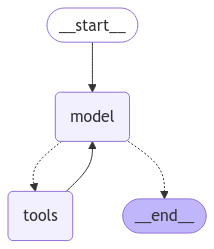

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

image_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)

display(Image(data=image_bytes))

**สิ่งที่ควรสังเกตที่นี่:**

- เราใช้เครื่องมือสองอย่างในตัวอย่างนี้: เครื่องมือค้นหาและเครื่องมือคำนวณ แต่คุณสามารถเพิ่มหรือแทนที่เครื่องมือที่เราใช้ได้อย่างง่ายดาย ในตัวอย่าง Python คุณยังเห็นตัวอย่างการสร้างเครื่องมือแบบกำหนดเองด้วย

- เราได้ใช้ฟังก์ชันความสะดวกสองอย่างที่มีมาพร้อมกับ LangGraph `ToolNode` ทำหน้าที่เป็นโหนดในกราฟของเราที่เรียกใช้การเรียกใช้งานเครื่องมือที่ร้องขอในข้อความ AI ล่าสุดที่พบในสถานะ และส่งคืน `ToolMessage` พร้อมผลลัพธ์ของแต่ละรายการ ToolNode ยังจัดการข้อยกเว้นที่ยกเว้นโดยเครื่องมือ โดยใช้ข้อความข้อผิดพลาดในการสร้าง `ToolMessage` ซึ่งจะถูกส่งต่อไปยัง LLM ซึ่งอาจตัดสินใจว่าจะทำอย่างไรกับข้อผิดพลาด

- `tools_condition` ทำหน้าที่เป็นฟังก์ชันขอบที่มีเงื่อนไขที่ดูที่ข้อความ AI ล่าสุดในสถานะและเส้นทางไปยังโหนด `tools` หากมีเครื่องมือใดๆ ที่จะเรียกใช้ มิฉะนั้น จะสิ้นสุดกราฟ

- สุดท้าย สังเกตว่ากราฟนี้วนซ้ำระหว่างโหนดโมเดลและโหนดเครื่องมือ นั่นคือ ตัวโมเดลเองที่รับผิดชอบในการตัดสินใจว่าจะหยุดการคำนวณเมื่อใด ซึ่งเป็นแอตทริบิวต์หลักของสถาปัตยกรรมตัวแทน เมื่อใดก็ตามที่เราเขียนลูปใน LangGraph เราอาจต้องการใช้ขอบที่มีเงื่อนไข เนื่องจากช่วยให้คุณสามารถกำหนดเงื่อนไขหยุดเมื่อกราฟควรออกจากลูปและหยุดการดำเนินการ



ตอนนี้มาดูกันว่ามันทำงานอย่างไรในตัวอย่างก่อนหน้านี้:

In [ ]:
from langchain.schema import HumanMessage

input = {
  "messages": [
    HumanMessage("How old was the 30th president of the United States when he died?")
  ]
}
for c in graph.stream(input):
    pprint(c)

{'model': {'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_RfNzNplpHwxAlvkhjvwRDJR5', 'function': {'arguments': '{"query":"30th president of the United States age at death"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 118, 'total_tokens': 145, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a64371fe-5066-44b9-a741-46f5005d1756-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': '30th president of the United States age at death'}, 'id': 'call_RfNzNplpHwxAlvkhjvwRDJR5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 118, 'output_tokens': 27, 'total_tokens': 

**เดินผ่านเอาต์พุตนี้:**

1. ครั้งแรก โหนด `model` ได้เรียกใช้และตัดสินใจเรียกใช้เครื่องมือ `duckduckgo_search` ซึ่งนำไปสู่ขอบที่มีเงื่อนไขเพื่อนำเราไปยังโหนด tools หลังจากนั้น

2. โหนด tools ได้เรียกใช้เครื่องมือค้นหาและรับผลลัพธ์การค้นหาที่พิมพ์ไว้ข้างต้น ซึ่งจริง ๆ แล้วมีคำตอบ “Age and Year of Death . January 5, 1933 (aged 60)”

3. เครื่องมือ `model` ได้รับการเรียกใช้ครั้งที่สอง คราวนี้มีผลลัพธ์การค้นหาเป็นข้อความล่าสุด และสร้างคำตอบขั้นสุดท้าย (และไม่มีการเรียกใช้งานเครื่องมือเพิ่มเติม) ดังนั้น ขอบที่มีเงื่อนไขจึงสิ้นสุดกราฟ

**ต่อไป มาดูส่วนขยายที่มีประโยชน์บางอย่างของสถาปัตยกรรมตัวแทนพื้นฐานนี้ ซึ่งปรับแต่งทั้งการวางแผนและการเรียกใช้งานเครื่องมือ**

#  Always Calling a Tool First

ในสถาปัตยกรรมตัวแทนมาตรฐาน LLM จะถูกเรียกใช้เสมอเพื่อตัดสินใจว่าจะเรียกใช้งานเครื่องมือใดต่อไป การจัดเรียงนี้มีข้อดีอย่างชัดเจน: มันให้ความยืดหยุ่นสูงสุดแก่ LLM ในการปรับพฤติกรรมของแอปพลิเคชันให้เหมาะสมกับแต่ละคิวรีของผู้ใช้ที่เข้ามา แต่ความยืดหยุ่นนี้มาพร้อมกับต้นทุน: การคาดเดาไม่ได้ ตัวอย่างเช่น หากคุณ ผู้พัฒนาแอปพลิเคชัน ทราบว่าควรเรียกใช้เครื่องมือค้นหาเสมอ นั่นอาจเป็นประโยชน์ต่อแอปพลิเคชันของคุณจริง ๆ:

1. จะช่วยลดเวลาแฝงโดยรวม เนื่องจากจะข้ามการเรียกใช้งาน LLM ครั้งแรกที่จะสร้างคำขอเพื่อเรียกใช้เครื่องมือค้นหา

2. จะป้องกันไม่ให้ LLM ตัดสินใจผิดพลาดว่าไม่จำเป็นต้องเรียกใช้เครื่องมือค้นหาสำหรับคิวรีของผู้ใช้บางรายการ

ในทางกลับกัน หากแอปพลิเคชันของคุณไม่มีกฎที่ชัดเจนในลักษณะ **“คุณควรเรียกใช้เครื่องมือนี้เสมอ”** การนำข้อจำกัดนี้มาใช้จริง ๆ แล้วจะทำให้แอปพลิเคชันของคุณแย่ลง

มาดูกันว่าสิ่งนี้มีลักษณะอย่างไร:

In [ ]:
import ast
from typing import Annotated, TypedDict
from uuid import uuid4

from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.messages import AIMessage, HumanMessage, ToolCall
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI

from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

@tool
def calculator(query: str) -> str:
    """A simple calculator tool. Input should be a mathematical expression."""
    return ast.literal_eval(query)

search = DuckDuckGoSearchRun()
tools = [search, calculator]
model = ChatOpenAI(temperature=0.1).bind_tools(tools)

class State(TypedDict):
    messages: Annotated[list, add_messages]

def model_node(state: State) -> State:
    res = model.invoke(state["messages"])
    return {"messages": res}

def first_model(state: State) -> State:
    query = state["messages"][-1].content
    search_tool_call = ToolCall(
        name="duckduckgo_search", args={"query": query}, id=uuid4().hex
    )
    return {"messages": AIMessage(content="", tool_calls=[search_tool_call])}

builder = StateGraph(State)
builder.add_node("first_model", first_model)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "first_model")
builder.add_edge("first_model", "tools")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")

graph = builder.compile()

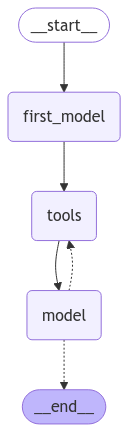

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

image_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)

display(Image(data=image_bytes))

**สังเกตความแตกต่างเมื่อเทียบกับหัวข้อก่อนหน้า**:

- ตอนนี้เราเริ่มการเรียกใช้งานทั้งหมดโดยการเรียก `first_model` ซึ่งไม่ได้เรียกใช้งาน LLM เลย มันแค่สร้างการเรียกใช้งานเครื่องมือสำหรับเครื่องมือค้นหา โดยใช้ข้อความของผู้ใช้ตามตัวอักษรเป็นคิวรีการค้นหา สถาปัตยกรรมก่อนหน้านี้จะมี LLM สร้างการเรียกใช้งานเครื่องมือนี้ (หรือการตอบกลับอื่นๆ ที่ถือว่าดีกว่า)

- หลังจากนั้น เราดำเนินการต่อที่ tools ซึ่งเหมือนกับตัวอย่างก่อนหน้า และจากที่นั่นเราดำเนินการต่อที่โหนด agent เช่นเดียวกับก่อนหน้านี้

ตอนนี้มาดูตัวอย่างเอาต์พุตกัน สำหรับคิวรีเดียวกันกับก่อนหน้านี้:

In [ ]:
input = {
  "messages": [
    HumanMessage("How old was the 30th president of the United States when he died?")
  ]
}
for c in graph.stream(input):
  pprint(c)

{'first_model': {'messages': AIMessage(content='', additional_kwargs={}, response_metadata={}, id='48b46a1d-489c-41c4-80a3-496540ec16ae', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'How old was the 30th president of the United States when he died?'}, 'id': '3ef0cbecfbf646b598e53fff596144a9', 'type': 'tool_call'}])}}
{'tools': {'messages': [ToolMessage(content='Calvin Coolidge (born John Calvin Coolidge Jr. [1] / ˈ k uː l ɪ dʒ / KOOL-ij; July 4, 1872 - January 5, 1933) was the 30th president of the United States, serving from 1923 to 1929.A Republican lawyer from Massachusetts, he previously served as the 29th vice president from 1921 to 1923 under President Warren G. Harding, and as the 48th governor of Massachusetts from 1919 to 1921. Cleveland is counted as the 22nd and 24th president of the United States, while Trump is counted as the 45th and 47th president. [7] [8] The presidency of William Henry Harrison, who died 31 days after taking office in 1841, was the shor

สิ่งที่เกิดขึ้นในครั้งนี้คือ เราข้ามการเรียกใช้งาน LLM ครั้งแรก เนื่องจากเราไปที่โหนด first_model ก่อน ซึ่งส่งคืนการเรียกใช้งานเครื่องมือสำหรับเครื่องมือค้นหาโดยตรง จากนั้นเราไปยังโฟลว์ก่อนหน้า กล่าวคือ เราได้เรียกใช้เครื่องมือค้นหาและสุดท้ายก็กลับไปที่โหนด model เพื่อสร้างคำตอบขั้นสุดท้าย

**ต่อไป มาดูกันว่าคุณจะทำอย่างไรเมื่อคุณมีเครื่องมือมากมายที่คุณต้องการให้ LLM สามารถเข้าถึงได้**



# Dealing with Many Tools

LLM ยังไม่สมบูรณ์แบบและปัจจุบันประสบปัญหามากขึ้นเมื่อได้รับตัวเลือกหรือข้อมูลเพิ่มเติมในพรอมต์ สิ่งนี้ยังขยายไปถึงการวางแผนการกระทำถัดไปที่จะดำเนินการด้วย เมื่อได้รับเครื่องมือจำนวนมาก (เช่น มากกว่า 10 เครื่องมือ) ประสิทธิภาพการวางแผน (นั่นคือ การเลือกเครื่องมือที่ถูกต้อง) เริ่มลดลง
- วิธีแก้ปัญหานี้คือการลดจำนวนเครื่องมือที่ LLM สามารถเลือกได้ แต่จะเกิดอะไรขึ้นถ้าคุณมีเครื่องมือจำนวนมากที่คุณต้องการให้ใช้สำหรับคิวรีของผู้ใช้ที่แตกต่างกัน

โซลูชันที่หรูหราคือการใช้ **ขั้นตอน RAG**

- เพื่อเลือกเครื่องมือที่เกี่ยวข้องมากที่สุดสำหรับคิวรีปัจจุบันล่วงหน้า จากนั้นป้อนชุดย่อยของเครื่องมือนั้นให้กับ LLM แทนที่จะเป็นคลังแสงทั้งหมด

- สิ่งนี้ยังสามารถช่วยลดต้นทุนของการเรียกใช้งาน LLM ได้อีกด้วย (LLM เชิงพาณิชย์มักจะเรียกเก็บเงินตามความยาวของพรอมต์และเอาต์พุต)

**ในทางกลับกัน ขั้นตอน RAG นี้จะเพิ่มเวลาแฝงให้กับแอปพลิเคชันของคุณ ดังนั้นควรดำเนินการเมื่อคุณเห็นประสิทธิภาพลดลงหลังจากเพิ่มเครื่องมือเพิ่มเติม**

มาดูวิธีการทำกัน:

In [ ]:
import ast
from typing import Annotated, TypedDict

from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langchain_core.vectorstores.in_memory import InMemoryVectorStore
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

@tool
def calculator(query: str) -> str:
    """A simple calculator tool. Input should be a mathematical expression."""
    return ast.literal_eval(query)

search = DuckDuckGoSearchRun()
tools = [search, calculator]

embeddings = OpenAIEmbeddings()
model = ChatOpenAI(temperature=0.1)

tools_retriever = InMemoryVectorStore.from_documents(
    [Document(tool.description, metadata={"name": tool.name}) for tool in tools],
    embeddings,
).as_retriever()

class State(TypedDict):
    messages: Annotated[list, add_messages]
    selected_tools: list[str]

def model_node(state: State) -> State:
    selected_tools = [
        tool for tool in tools if tool.name in state["selected_tools"]
    ]
    res = model.bind_tools(selected_tools).invoke(state["messages"])
    return {"messages": res}

def select_tools(state: State) -> State:
    query = state["messages"][-1].content
    tool_docs = tools_retriever.invoke(query)
    return {"selected_tools": [doc.metadata["name"] for doc in tool_docs]}

builder = StateGraph(State)
builder.add_node("select_tools", select_tools)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "select_tools")
builder.add_edge("select_tools", "model")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")

graph = builder.compile()

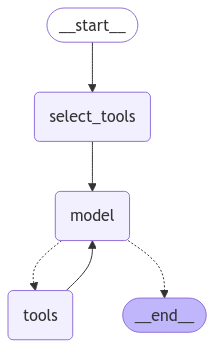

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

image_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)

display(Image(data=image_bytes))

**หมายเหตุ**

สิ่งนี้คล้ายกับสถาปัตยกรรมตัวแทนทั่วไปมาก ความแตกต่างเพียงอย่างเดียวคือเราหยุดที่โหนด `select_tools` ก่อนเข้าสู่ลูปตัวแทนจริง หลังจากนั้น มันทำงานเหมือนกับสถาปัตยกรรมตัวแทนทั่วไปที่เราเคยเห็นมาก่อน

ตอนนี้มาดูตัวอย่างเอาต์พุตกัน สำหรับคิวรีเดียวกันกับก่อนหน้านี้:

In [ ]:
input = {
  "messages": [HumanMessage("How old was the 30th president of the United States when he died?")]
}
for c in graph.stream(input):
  pprint(c)

{'select_tools': {'selected_tools': ['duckduckgo_search', 'calculator']}}
{'model': {'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_SfLElZ5hVlKMO1ZrFDq5MurW', 'function': {'arguments': '{"query":"30th president of the United States age at death"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 118, 'total_tokens': 145, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7d40ff4d-178f-4036-9828-08e192f90698-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': '30th president of the United States age at death'}, 'id': 'call_SfLElZ5hVlKMO1ZrFDq5MurW', 'type': 'tool_call'}], 

สังเกตว่าสิ่งแรกที่เกิดขึ้นคือเราได้สอบถาม `retriever` เพื่อรับเครื่องมือที่เกี่ยวข้องมากที่สุดสำหรับคิวรีของผู้ใช้ปัจจุบัน จากนั้นเราดำเนินการต่อที่สถาปัตยกรรมตัวแทนทั่วไป

# Summary
**สรุป**

บทนี้ได้แนะนำแนวคิดของ ตัวแทน และกล่าวถึงสิ่งที่ต้องใช้ในการสร้างแอปพลิเคชัน LLM ตัวแทน: การให้ความสามารถแก่ LLM ในการตัดสินใจระหว่างตัวเลือกหลายตัว โดยใช้ข้อมูลภายนอก

เราได้เดินผ่านสถาปัตยกรรมตัวแทนมาตรฐานที่สร้างขึ้นด้วย LangGraph และดูส่วนขยายที่มีประโยชน์สองอย่าง:
- วิธีการเรียกใช้เครื่องมือเฉพาะก่อนเสมอ
- และวิธีการจัดการกับเครื่องมือจำนวนมาก

**บทที่ 7 จะกล่าวถึงส่วนขยายเพิ่มเติมของสถาปัตยกรรมตัวแทน**